# AutoEncoder UNO

In [67]:
import numpy as np 
import pandas as pd
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split

## Data Cleaning

In [68]:
os.chdir("/Users/jakegwinn/Documents/argonne_F24/UNO.jw")
wd = os.getcwd()
datapath = os.path.join(wd, "csa_data/raw_data/y_data/response.tsv")
df = pd.read_csv(datapath, sep="\t")

/var/folders/w_/tv9kwn955c59q5gycbr00lzh0000gn/T/ipykernel_97259/254425380.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datapath, sep="\t")


In [69]:
# Making the Time values appropriate for future work 
# df['Time'] = df['Time'].apply(lambda x : (x / 3600) % 24) 
  
# Separating the normal and fraudulent transactions 
effective = df[df['auc'] <= 0.4] 
# normal = df[df['Class']== 0]
# normal = df[df['Class']== 0].sample(2500)
non_effective = df[df['auc'] > 0.4]

# Reducing the dataset because of machinery constraints 
df = pd.concat([non_effective, effective], ignore_index=True)
df1 = df.drop(columns=["source", "improve_sample_id", "improve_chem_id", "study"])
df2 = df1.dropna()
# Separating the dependent and independent variables 
y = (df2['auc'] <= 0.4).astype(int)
X = df2.drop('auc', axis = 1)
print(y)

0         0
2         0
3         0
4         0
5         0
         ..
587704    1
587705    1
587706    1
587707    1
587708    1
Name: auc, Length: 359234, dtype: int64


In [70]:
np.mean(df2["auc"] <= 0.4)

0.035993252309079876

In [71]:
def tsne_plot(x, y): 
      
    # Setting the plotting background 
    sns.set_theme(style ="whitegrid") 
      
    tsne = TSNE(n_components = 2, random_state = 0) 
      
    # Reducing the dimensionality of the data 
    X_transformed = tsne.fit_transform(x) 
  
    plt.figure(figsize =(12, 8)) 
      
    # Building the scatter plot 
    plt.scatter(X_transformed[np.where(y == 0), 0],  
                X_transformed[np.where(y == 0), 1], 
                marker ='o', color ='y', linewidth =1, 
                alpha = 0.8, label ='Normal') 
    plt.scatter(X_transformed[np.where(y == 1), 0], 
                X_transformed[np.where(y == 1), 1], 
                marker ='o', color ='k', linewidth =1, 
                alpha = 0.8, label ='Fraud') 
  
    # Specifying the location of the legend 
    plt.legend(loc ='best') 
      
    # Plotting the reduced data 
    plt.show() 

## Plotting Pre-encdoed Data

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:106: RuntimeWarning: overflow encountered in cast
  distances_data = distances_data.astype(np.float32, copy=False)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


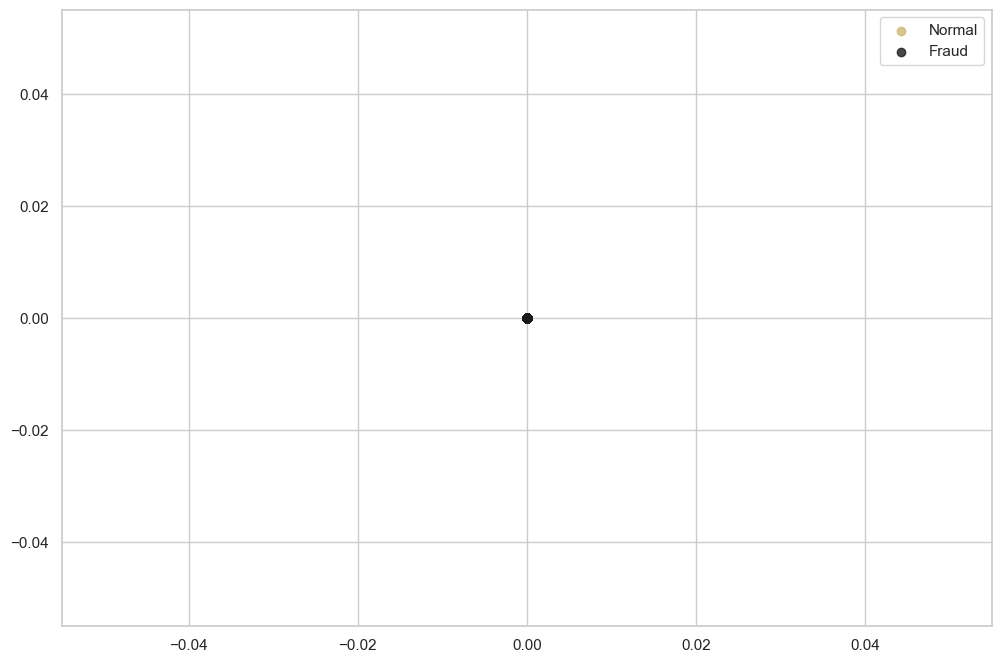

In [72]:
tsne_plot(X, y)

In [73]:
# Scaling the data to make it suitable for the auto-encoder 
X_scaled = MinMaxScaler().fit_transform(X) 
X_normal_scaled = X_scaled[y > 0.4] 
X_fraud_scaled = X_scaled[y <= 0.4] 

In [ ]:
print(X_normal_scaled.shape)
print(X_fraud_scaled.shape)

(12930, 9)
(346304, 9)


## Building AutoEncoder

In [75]:
input_layer = tf.keras.layers.Input(shape = (X.shape[1], ))

# Encoder Network
encoded = tf.keras.layers.Dense(8, activation='tanh', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_layer)
encoded = tf.keras.layers.Dense(7, activation='tanh', activity_regularizer=tf.keras.regularizers.l1(10e-5))(encoded)
encoded = tf.keras.layers.Dense(6, activation='tanh', activity_regularizer=tf.keras.regularizers.l1(10e-5))(encoded)
encoded = tf.keras.layers.Dense(5, activation='tanh', activity_regularizer=tf.keras.regularizers.l1(10e-5))(encoded)
encoded = tf.keras.layers.Dense(4, activation='relu')(encoded)

# Decoder Network
decoded = tf.keras.layers.Dense(5, activation='tanh')(encoded)
decoded = tf.keras.layers.Dense(6, activation='tanh')(decoded)
decoded = tf.keras.layers.Dense(7, activation='tanh')(decoded)
decoded = tf.keras.layers.Dense(8, activation='tanh')(decoded)

output_layer = tf.keras.layers.Dense(X.shape[1], activation="relu")(decoded)

In [76]:
autoencoder = tf.keras.models.Model(input_layer, output_layer)
autoencoder.compile(optimizer = "adadelta", loss="mse")

call_back = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5)

autoencoder.fit(X_normal_scaled, X_normal_scaled, 
                batch_size = 16, epochs = 150, 
                shuffle = True, validation_split = 0.2, 
                callbacks = [])



Epoch 1/150


647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - loss: 0.4582 - val_loss: 0.4430
Epoch 2/150
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.4499 - val_loss: 0.4357
Epoch 3/150
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.4424 - val_loss: 0.4270
Epoch 4/150
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 0.4328 - val_loss: 0.4166
Epoch 5/150
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.4214 - val_loss: 0.4045
Epoch 6/150
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.4073 - val_loss: 0.3902
Epoch 7/150
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 0.3905 - val_loss: 0.3731
Epoch 8/150
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.3708 - val_loss: 0.3527
Epoch 9/150
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 0.3487 - val_loss: 0.3283
Epoch 10/150
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.3202 - val_loss: 0.2994
Epoch 11/150
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.2861 - val_loss: 0.2659
Epoch 12/150
647/647 ━━━━━━━━━━

## Keep the Encoder Part of Data

In [77]:
hidden_representation = tf.keras.models.Sequential() 
hidden_representation.add(autoencoder.layers[0]) 
hidden_representation.add(autoencoder.layers[1]) 
hidden_representation.add(autoencoder.layers[2]) 
hidden_representation.add(autoencoder.layers[3]) 
hidden_representation.add(autoencoder.layers[4]) 

In [78]:
# Separating the points encoded by the Auto-encoder as normal and fraud 
normal_hidden_rep = hidden_representation.predict(X_normal_scaled)
fraud_hidden_rep = hidden_representation.predict(X_fraud_scaled)

# Combining the encoded points into a single table
encoded_X = np.append(normal_hidden_rep, fraud_hidden_rep, axis = 0) 
y_normal = np.zeros(normal_hidden_rep.shape[0]) 
y_fraud = np.ones(fraud_hidden_rep.shape[0]) 
encoded_y = np.append(y_normal, y_fraud)

405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
10822/10822 ━━━━━━━━━━━━━━━━━━━━ 2s 198us/step


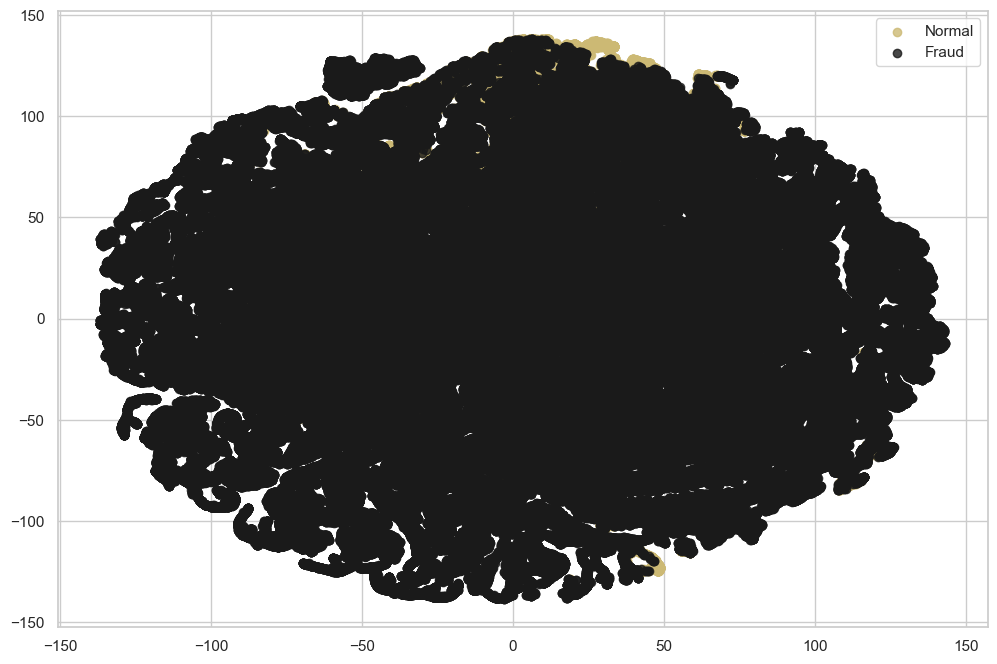

In [79]:
tsne_plot(encoded_X, encoded_y) 

## Logistic Regression with Encoded data

In [80]:
# Splitting the encoded data for linear classification 
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_X, encoded_y, test_size = 0.2) 
  
# Splitting the original data for non-linear classification 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

In [81]:
# Building the logistic regression model 
lrclf = LogisticRegression() 
lrclf.fit(X_train_encoded, y_train_encoded) 
  
# Storing the predictions of the linear model 
y_pred_lrclf = lrclf.predict(X_test_encoded) 

In [82]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test_encoded, y_pred_lrclf))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.81      0.49      0.61      2580
         1.0       0.98      1.00      0.99     69267

    accuracy                           0.98     71847
   macro avg       0.90      0.74      0.80     71847
weighted avg       0.98      0.98      0.97     71847

